In [1]:
import random
import copy
import numpy as np
import pandas as pd
import scipy.signal
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

### Signal generation

For testing, make a test signal and time axis for the signal; sawtooth every 20 samples with some noise.

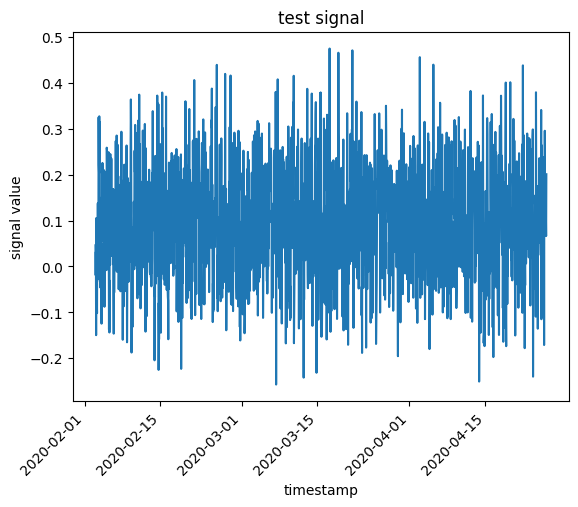

In [75]:
n_sample = 2000
s = (np.arange(n_sample) % 20) * 0.01 + np.random.normal(0, 0.1, n_sample)
t = [datetime(2020, 2, 3) + timedelta(hours=x) for x in range(n_sample)]
df = pd.DataFrame()
df["data"] = s
df["timestamp"] = t
df = df.set_index("timestamp")
plt.plot(df)
plt.xlabel("timestamp")
plt.ylabel("signal value")
plt.title("test signal")
_ = plt.xticks(rotation=45, ha="right")

The sawtooth lasts 20 samples, with a max amplitude of 0.2, and white Gaussian noise with $\sigma$ = 0.1 added onto the sawtooth.

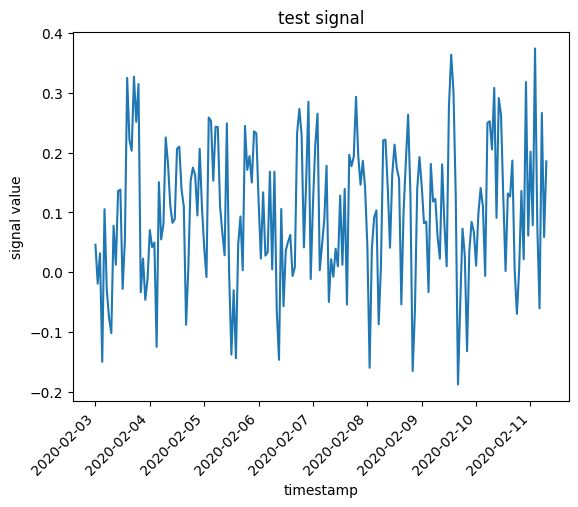

In [76]:
plt.plot(df[:200])
plt.xlabel("timestamp")
plt.ylabel("signal value")
plt.title("test signal")
_ = plt.xticks(rotation=45, ha="right")

### Stationarity and Autocorrelation analysis for ARIMA modelling

Function from [2] for some quick analysis. The Augmented Dickey-Fuller test is the useful part.

In [4]:
result = adfuller(df["data"])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -8.031703058353987
p-value: 1.950476431435263e-12
Critical Values:
	1%: -3.4336603168110695
	5%: -2.8630023108088545
	10%: -2.5675484732666


The Augmented Dickey Fuller test has a low p-value. As per [3], the alternative hypothesis is that the signal is stationary (possibly with trend). This means one can consider the signal to be stationary (as expected, since the signal is a noise sawtooth). If the signal were not stationary, when can start performing repeated diffs on the signal to try and get a stationary signal. The number of diffs to apply then becomes the $d$ in ARIMA. Since no diffs need to be performed, $d = 0$ for ARIMA below.

Performing an auto correlation of signal allows exploration of periodicity. The auto correlation shows autocorrelation peaks every 20 samples.

The autocorrelation tends to be useful for understanding the value to use for $q$, the number of moving average taps in ARIMA [5]. The points above the confidence interval at around 20 taps suggest using a $q$ of 20 to 25. 

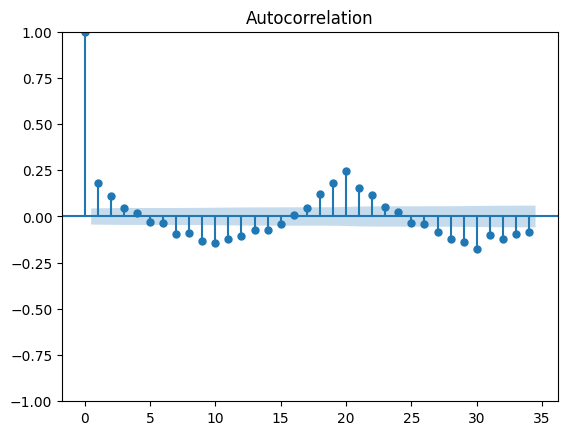

In [6]:
_ = plot_acf(s)

The partial autocorrelation tends to be useful for understanding the value to use for $p$, the number of autoregression taps in ARIMA [5]. The points above the confidence interval at around 20 taps suggest using a $p$ of 20 to 25. 

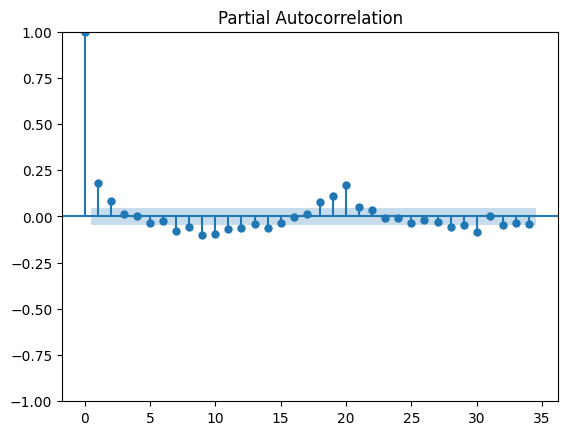

In [7]:
_ = plot_pacf(s, method="ywm")

### ARIMA modelling

This is a timeseries modelling method to recover and predict the original noiseless signal.

The practical implementation of the parameters are in [2], and theoretical aspects covered in [4].

Since the periodicity is 20 samples, using an auto-regression number of taps greater than the periodicity (which is what $p$ gives) allows the periodic behaviour to be captured in the prediction. Increasing the number of tap in the moving average (which is what $q$ gives) prolongs the periodic behaviour in the predicted samples. The respective sensible values for $p$ and $q$ can be obtained from the ACF and PACF.

Since the signal is already stationary, $d=0$.

For the in-sample modelling, the modelled signal captures the sawtooth of aplitude 0.2.

In [8]:
def plot_arima_results(p, d, q, signal, timestamps, n_fit=1000, alpha=0.05):
    s = signal
    t = timestamps
    model = ARIMA(s[:n_fit], order=(p, d, q), dates=t[:n_fit])
    results = model.fit()

    plt.plot(t, s, label="original signal")
    plt.plot(t[:n_fit], results.fittedvalues, color="red", label=f"ARIMA{(p,d,q)} fitted values")

    predictions = results.predict(start=n_fit, end=n_sample-1)
    plt.plot(t[n_fit:], predictions, color="orange", label="prediction")

    forecast = results.get_forecast(n_sample - n_fit).conf_int(alpha=alpha)

    plt.fill_between(t[n_fit:], [x[0] for x in forecast], [x[1] for x in forecast], color=(0.01, 0.4, 0.6, 0.2), label=f"alpha={alpha} confidence interval")
    plt.legend(loc="upper left")
    plt.xlabel("timestamp")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("signal value")
    plt.title("ARIMA modelling of signal")

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


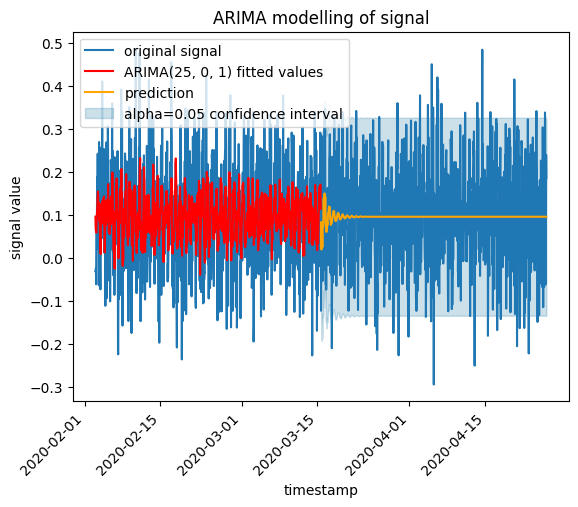

In [9]:
# too short a moving average window means that there are not enough white noise generators to 
# 'drive' the process, and the process dies away
plot_arima_results(25, 0, 1, s, t)

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

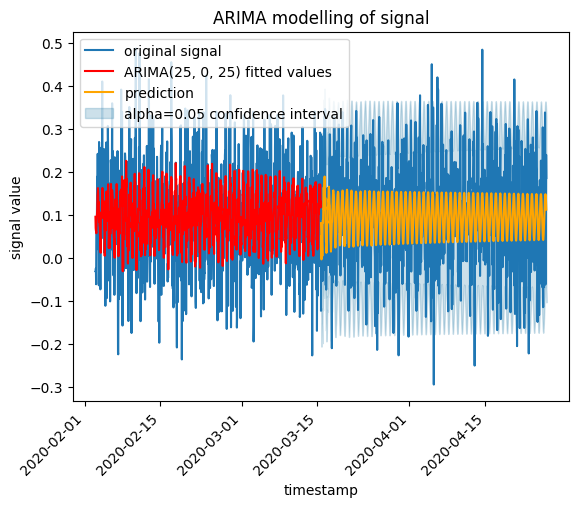

In [11]:
# this is the suggested p and q from ACF and PACF
plot_arima_results(25, 0, 25, s, t)

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

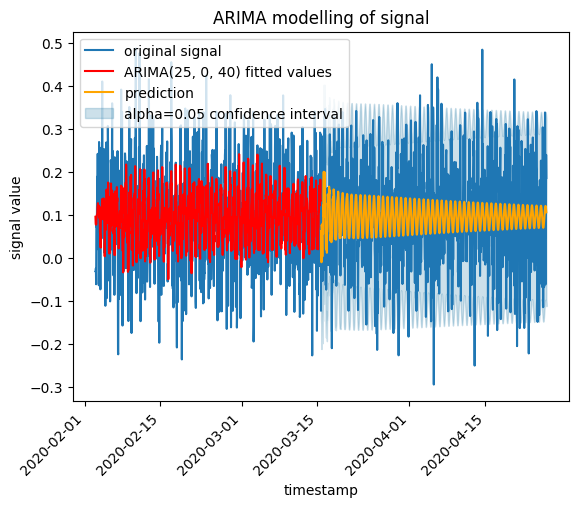

In [12]:
# supplying more moving average taps than that suggested by ACF doesn't help much
# and introduces more compute at the 'fit' stage 
plot_arima_results(25, 0, 40, s, t)

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

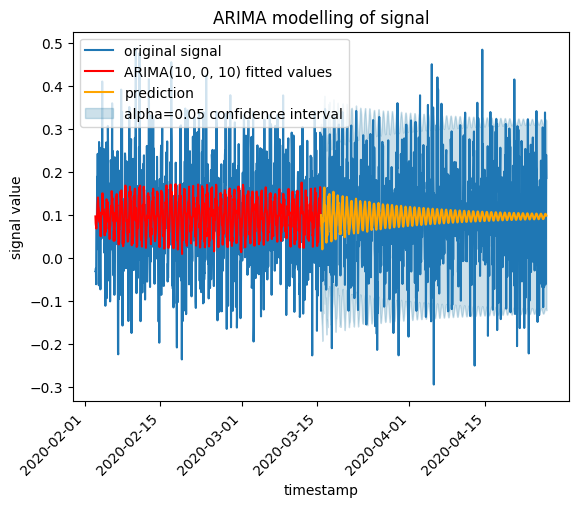

In [13]:
# smaller values of p and q can still work, and are more computationally efficient to calculate the model
plot_arima_results(10, 0, 10, s, t)

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

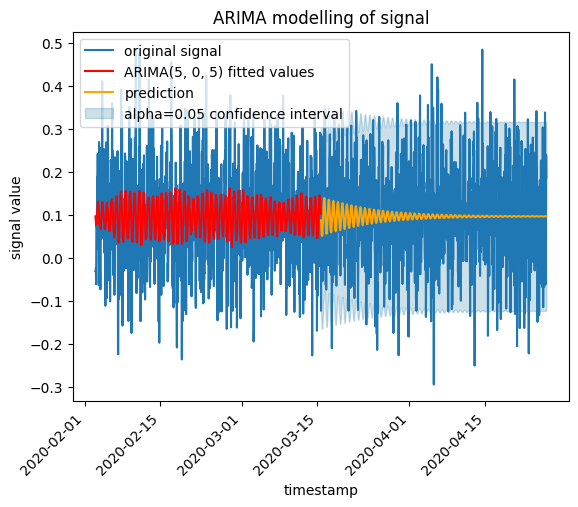

In [14]:
# values of p and q that are too small will yield too simplistic a model
plot_arima_results(5, 0, 5, s, t)

### Theoretical aspects of ARIMA

[3], [4], [5], [6] give a good overview of the theoretical aspects, which won't be covered here. As a brief summary, one can consider the ARIMA model to be a refactor of an ARMA model, which itself is an IIR filter from white Gaussian noise to the signal domain in question. The moving average part represents the FIR part of the IIR filter applied onto the Gaussian source, and the auto-regressive part refers to the IIR part of the filter. The 'fit' part of ARIMA then works out what these filter taps should be by conditioning on the data (under the hood, it seems that statsmodels employs a Kalman filter to find the MLE estimate for the filter taps). As per standard IIR filter theory, the polynomial roots for polynomial lag equation describing the autoregression dictate whether or not the filter is causal (i.e. only depends on past values of the Gaussian source). The polynomial roots of the polynomial lag equation of the moving average part dictate whether or not the filter is invertible (i.e. if the Gaussian source terms can be expressed as past values of the signal).

The 'fit' method build the filter, and also solves for the underlying signal and Gaussian samples in the training data. The 'predict' or 'forecast' method then uses those values, the filter, and generates Gaussian samples to drive the process forward.

#### ARIMA as an Infinite Impulse Response (IIR) filter

On fitting a (10, 0, 10) model, one can pull out the parameters from the model that allow seeing the results as an order 10 IIR filter.

In [5]:
model = ARIMA(s[:1000], order=(10, 0, 10), dates=t[:1000])
results = model.fit()

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

In [9]:
print(results.model_orders)

{'trend': 0, 'exog': 1, 'ar': 10, 'ma': 10, 'seasonal_ar': 0, 'seasonal_ma': 0, 'reduced_ar': 10, 'reduced_ma': 10, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}


Below are effectively the taps of the IIR filter.

In [12]:
print(results.polynomial_ar)

[ 1.          0.86560391  0.40468356 -0.07243864 -0.33034233 -0.45260121
 -0.27740531 -0.0027207   0.50415084  0.9419807   0.77939661]


In [13]:
print(results.polynomial_ma)

[ 1.          0.8885766   0.41625694 -0.04498282 -0.2998062  -0.42400932
 -0.27046044 -0.01679833  0.48207876  0.92317732  0.7767031 ]


These taps can be extracted and applied to data as an IIR filter to obtain, for example, the impulse response.

In [54]:
n_sample = 300
b = results.polynomial_ma
a = results.polynomial_ar
delta_function = np.zeros(n_sample)
delta_function[20] = 1.0
filtered_delta_function = scipy.signal.lfilter(b, a, delta_function)

Text(0, 0.5, 'signal value')

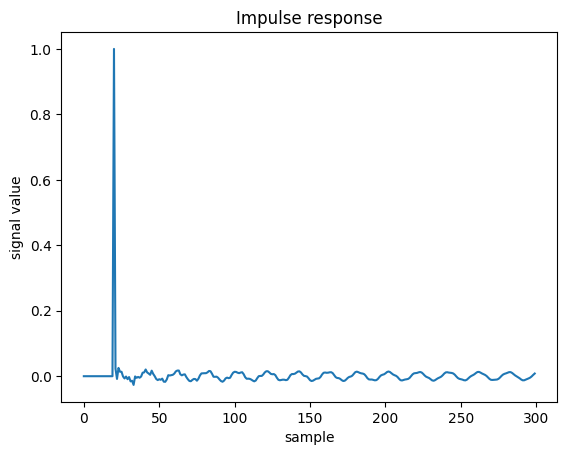

In [57]:
plt.plot(filtered_delta_function)
plt.title("Impulse response")
plt.xlabel("sample")
plt.ylabel("signal value")

The ARIMA model is defined [4] as a predictive model based on a linear combination of previous terms in the signal, and previous error terms (often taken to be normally distributed). Taking this definition in the IIR context, ARIMA becomes an IIR filter mapping error terms (here taken to be white Gaussian noise) to the signal domain.

In [63]:
normal_randoms = np.zeros(n_sample)
normal_randoms[:int(n_sample/2)] = np.random.normal(0, 1, int(n_sample/2))
filtered_normal_randoms = scipy.signal.lfilter(b, a, normal_randoms)

Text(0, 0.5, 'signal value')

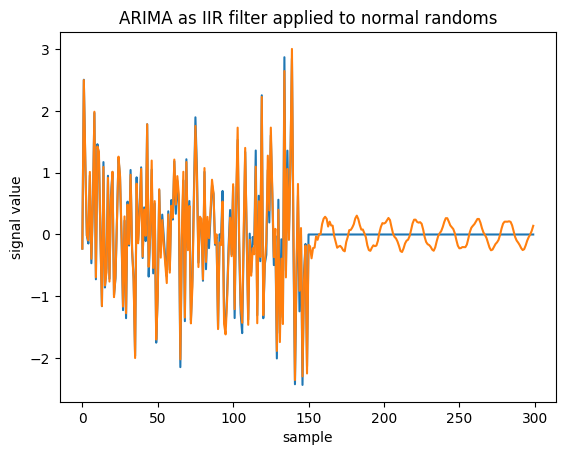

In [66]:
plt.plot(normal_randoms, label="normal randoms")
plt.plot(filtered_normal_randoms, label="filtered normal randoms")
plt.title("ARIMA as IIR filter applied to normal randoms")
plt.xlabel("sample")
plt.ylabel("signal value")

### Gaps in the data

How to handle gaps in the data, or when the dates are non-contiguous. The statsmodels docs [7] have examples of this.

In [15]:
# drop samples in the middle by nan-ing them
s_gap = copy.deepcopy(s)
s_gap[200:250] = np.nan

/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsnagi/miniconda3/envs/stats-play-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

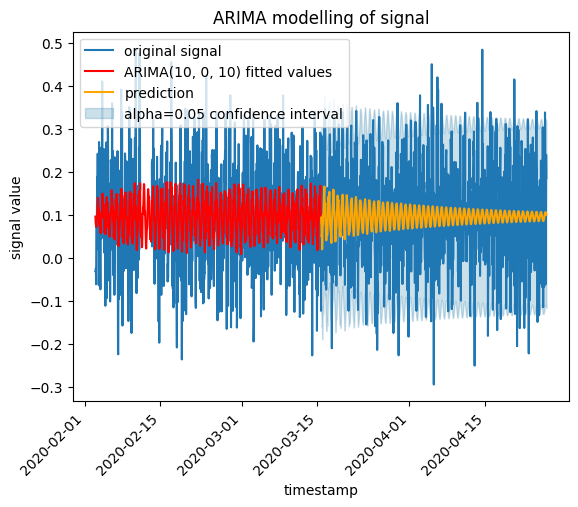

In [16]:
n_fit=1000
p, d, q = (10,0,10)

plot_arima_results(p, d, q, s_gap, t, n_fit=1000, alpha=0.05)

### References

[1] Statsmodels ARIMA docs https://www.statsmodels.org/0.8.0/generated/statsmodels.tsa.arima_model.ARIMA.html#statsmodels-tsa-arima-model-arima

[2] ARIMA Model Python Example — Time Series Forecasting https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

[3] Augmented Dickey Fuller test https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

[4] Autoregressive integrated moving average https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

[5] Autoregressive moving average https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model

[6] Autoregressive Moving Average Model ARMA(1,1) https://webspace.maths.qmul.ac.uk/b.bogacka/TimeSeries/TS_Chapter4_6.pdf

[7] SARIMAX example with missing data https://www.statsmodels.org/v0.11.1/examples/notebooks/generated/statespace_sarimax_internet.html